In [5]:
import torch, os
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
import matplotlib.pyplot as plt
from tqdm import tqdm
from einops import rearrange

from torchvision.utils import save_image, make_grid
from torchvision import transforms
from torchvision.datasets import MNIST

from modules.networks.Unet import ContextUnet

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use only the first GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1
val_dataset = MNIST("/data/edherron/data/MNIST", train=False, download=False, transform=tf)

val_loader = torch.utils.data.DataLoader(val_dataset, 
                                        batch_size=256, 
                                        shuffle=True, 
                                        drop_last=True, 
                                        num_workers=1
                                        )

class MLP(nn.Module):
    def __init__(self, input_dim=28**2, hidden_num=512):
        super().__init__()
        self.fc1 = nn.Linear(input_dim+1, hidden_num, bias=True)
        self.fc2 = nn.Linear(hidden_num, hidden_num, bias=True)
        self.fc3 = nn.Linear(hidden_num, input_dim, bias=True)
        self.act = lambda x: torch.tanh(x)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x_input, t):
        inputs = torch.cat([x_input, t], dim=1)
        x = self.fc1(inputs)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        return x

In [13]:
class RectifiedFlow():
    def __init__(self, model=None, device=None, num_steps=1000):
        self.model = MLP()
        self.model.to(device)
        self.N = num_steps
        self.device = device
        
    def get_train_tuple(self, z0=None, z1=None):
        t = torch.rand((z1.shape[0],1)).to(self.device)
        z_t = t * z1 + (1. - t) * z0
        target = z1 - z0
        return z_t, t, target
    
    @torch.no_grad()
    def sample_ode(self, z0=None, N=None):
        if N is None:
            N = self.N
        dt = 1./N
        trajectory = []
        z = z0.detach().clone().to(self.device)
        
        
        trajectory.append(z.detach().clone())
        for i in range(N):
            t = torch.ones((z.shape[0], 1)) * i / N
            t = t.to(self.device)
            pred = self.model(z, t)
            z = z.detach().clone() + pred * dt
            
            trajectory.append(z.detach().clone())
        return trajectory

In [14]:
def train_rectified_flow(data_loader, rectified_flow, opt, device):
    rectified_flow.model.train()
    running_loss = 0.0
    for data in data_loader:
        z1, _ = data
        z1 = rearrange(z1.to(device), 'b c h w -> b (c h w)')
        z0 = torch.randn_like(z1).to(device)
        
        z_t, t, target = rectified_flow.get_train_tuple(z0, z1)
        
        pred = rectified_flow.model(z_t, t)
        
        loss = F.mse_loss(pred, target)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

In [17]:
# Init all of our models
model = MLP()
RF = RectifiedFlow(model, device)

print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

opt = torch.optim.Adam(model.parameters(), lr=3e-4)

for i in tqdm(range(5)):
    loss_rec = train_rectified_flow(val_loader, RF, opt, device)
    print('loss from epoch ', i, ': ', loss_rec)

Number of parameters:  1067280


  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:01<00:04,  1.05s/it]

loss from epoch  0 :  1.124557464550703


 40%|████      | 2/5 [00:02<00:03,  1.03s/it]

loss from epoch  1 :  1.1245004947368915


 60%|██████    | 3/5 [00:03<00:02,  1.04s/it]

loss from epoch  2 :  1.125197178278214


 80%|████████  | 4/5 [00:04<00:01,  1.04s/it]

loss from epoch  3 :  1.124688411370302


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]

loss from epoch  4 :  1.1254921845900707


In [18]:
z = torch.randn((1,28**2))
trajectory = RF.sample_ode(z0 = z)

In [19]:
print(len(trajectory))

1001


In [24]:
print(len(trajectory))
print(type(trajectory[69]))
print(trajectory[69].shape)

1001
<class 'torch.Tensor'>
torch.Size([1, 784])


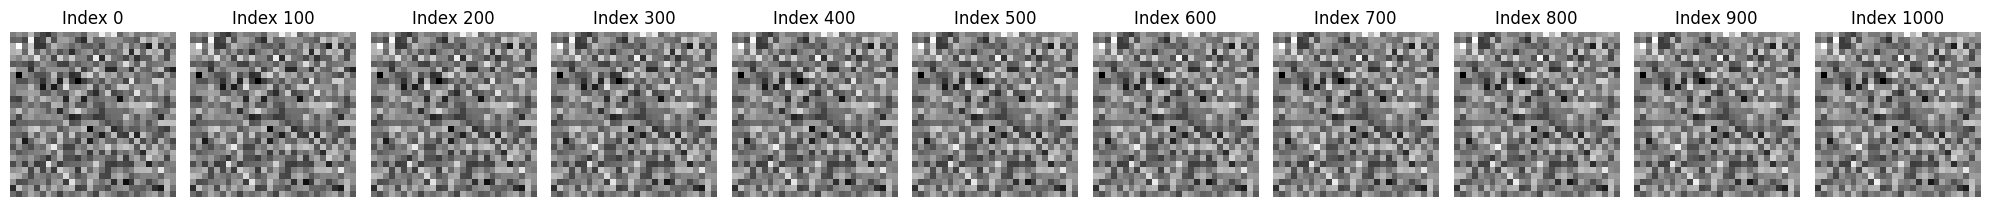

In [26]:
# Assuming `data_list` is your list of tensors
fig, axs = plt.subplots(1, 11, figsize=(20, 2))  # Adjust figsize as needed

for i, ax in enumerate(axs.flat):
    idx = i * 100  # Every 100th element
    if idx < len(trajectory):
        img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
        ax.imshow(img, cmap='gray')  # Plot as grayscale image
        ax.set_title(f'Index {idx}')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for plots beyond the list length

plt.tight_layout()
plt.show()


In [ ]:
def train_loop(data_loader, ae, opt, device):
    ae.train()
    running_loss = 0.0
    for data in data_loader:
        images, _ = data
        images = rearrange(images.to(device), 'b c h w -> b (c h w)')
        recon = ae(images)
        loss = F.mse_loss(recon, images)
        loss.backward()
        opt.step()
        opt.zero_grad()
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

In [ ]:
# Init all of our models
ae = MLP_AE()
ae.to(device)
print("Number of parameters: ", sum(p.numel() for p in ae.parameters()))

opt = torch.optim.Adam(ae.parameters(), lr=3e-4)

for i in tqdm(range(25)):
    loss_rec = train_loop(val_loader, ae, opt, device)
    print('loss from epoch ', i, ': ', loss_rec)

In [ ]:
ae.eval()
image, label = val_dataset[737]
image = rearrange(image.to(device), 'b h w -> b (h w)')
pred = ae(image)
pred = rearrange(pred, 'b (h w) -> b h w', h=28, w=28)
image = rearrange(image, 'b (h w) -> b h w', h=28, w=28)

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(image.detach().cpu().squeeze().numpy())
ax3.imshow(pred.detach().cpu().squeeze().numpy())